## Credit Score Classification - Regression

Dataset: https://www.kaggle.com/datasets/parisrohan/credit-score-classification?utm 

# 
The dataset includes details about people’s financial situations and credit habits, like their income, number of credit lines, total debt, and payment history. While it was originally meant for classification, figuring out if someone’s credit score is “Good,” “Standard,” or “Poor” for this project I’m using it for regression to predict an actual numeric credit score.

Goal:
The main goal is to build and compare different regression models that can estimate a person’s credit score based on their financial and demographic data.

Motivation:
Credit scores play a big role in helping banks and lenders decide how likely someone is to pay back a loan. Creating predictive models like this can make the process of evaluating credit more efficient, as long as the models are trained in a fair and transparent way.

## What is Regression?

Regression is a statistical and machine learning method used to understand the relationship between variables and predict outcomes. It looks at how one or more independent variables can be used to predict a dependent variable (output). The goal is to find a mathematical equation that shows how changes in the inputs affect the output. Linear regression is one of the simplest and most common types of regression. It assumes that the relationship between the input and output variables is linear, meaning it can be represented as a straight line. The general equation for simple linear regression, when there is only one independent variable, is: Y = β0 + β1X + ε


## Preprocessing

In [1]:
import pandas as pd
import numpy as np

# Update the filename if different
DATA_FILENAME = '/Users/htallapr/Downloads/test.csv'
df = pd.read_csv(DATA_FILENAME)

# Quick overview
print('Dataset shape:', df.shape)
display(df.head())

# Detect missing values
print('\nMissing values:')
print(df.isna().sum().sort_values(ascending=False).head(20))

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Map categorical target to numeric if necessary
if 'Credit_Score' in df.columns and df['Credit_Score'].dtype == object:
    mapping = {'Poor':400, 'Standard':650, 'Good':800,
               'poor':400, 'standard':650, 'good':800}
    df['Credit_Score'] = df['Credit_Score'].map(mapping)

# Remove target from numeric_cols if present
if 'Credit_Score' in numeric_cols:
    numeric_cols.remove('Credit_Score')

print('\nNumeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)
print(df.columns.tolist())

Dataset shape: (50000, 27)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923



Missing values:
Monthly_Inhand_Salary       7498
Type_of_Loan                5704
Name                        5015
Credit_History_Age          4470
Num_of_Delayed_Payment      3498
Amount_invested_monthly     2271
Num_Credit_Inquiries        1035
Monthly_Balance              562
Annual_Income                  0
Credit_Mix                     0
Payment_Behaviour              0
Month                          0
Total_EMI_per_month            0
Payment_of_Min_Amount          0
Age                            0
Credit_Utilization_Ratio       0
Outstanding_Debt               0
SSN                            0
Num_Bank_Accounts              0
Changed_Credit_Limit           0
dtype: int64

Numeric columns: ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month']
Categorical columns: ['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Num_o

## Experiment 1 : Baseline Linear Regression

Test RMSE: 9581.383965139323


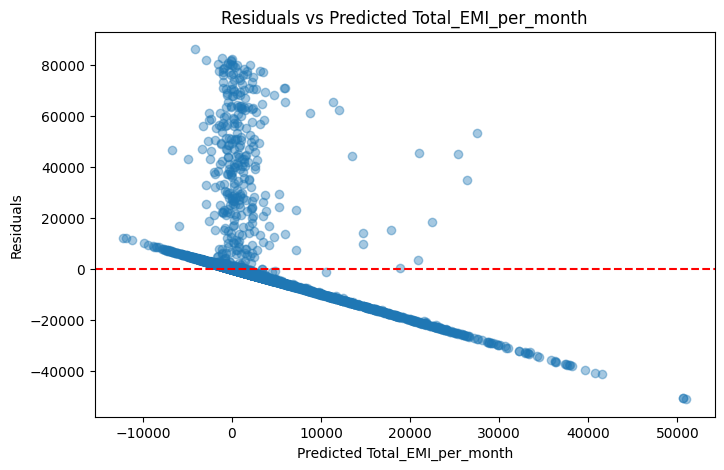

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# --- Choose a numeric target for regression ---
target_column = 'Total_EMI_per_month'  # Change this if you want another numeric column
y = df[target_column]

# --- Drop target and non-informative ID columns ---
X = df.drop(columns=[target_column, 'ID', 'Customer_ID', 'Name', 'SSN'])

# --- Separate numeric and categorical features ---
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# --- Preprocessing pipelines ---
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression pipeline ---
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# --- Train model ---
lr_pipeline.fit(X_train, y_train)

# --- Predict ---
y_pred = lr_pipeline.predict(X_test)

# --- Compute RMSE manually for compatibility ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Test RMSE:', rmse)

# --- Residual plot ---
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel(f'Predicted {target_column}')
plt.ylabel('Residuals')
plt.title(f'Residuals vs Predicted {target_column}')
plt.show()


## Experiment 2: Feature Engineering + Ridge Regression

The goal of this part of the project is to improve the baseline model by adding polynomial interaction features and using regularization through Ridge Regression. Polynomial features help capture nonlinear relationships between variables, which can make the model more accurate. Ridge Regression is then applied to reduce overfitting by penalizing large coefficient values. Finally, the regularization parameter α is tuned using cross-validation to find the best balance between bias and variance.

✅ Dataset loaded successfully!
Shape: (50000, 27)
       ID Customer_ID      Month             Name  Age          SSN  \
0  0x160a   CUS_0xd40  September    Aaron Maashoh   23  821-00-0265   
1  0x160b   CUS_0xd40    October    Aaron Maashoh   24  821-00-0265   
2  0x160c   CUS_0xd40   November    Aaron Maashoh   24  821-00-0265   
3  0x160d   CUS_0xd40   December    Aaron Maashoh  24_  821-00-0265   
4  0x1616  CUS_0x21b1  September  Rick Rothackerj   28  004-07-5839   

  Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0  Scientist      19114.12            1824.843333                  3  ...   
1  Scientist      19114.12            1824.843333                  3  ...   
2  Scientist      19114.12            1824.843333                  3  ...   
3  Scientist      19114.12                    NaN                  3  ...   
4    _______      34847.84            3037.986667                  2  ...   

   Num_Credit_Inquiries  Credit_Mix Outstanding_Debt Credit_

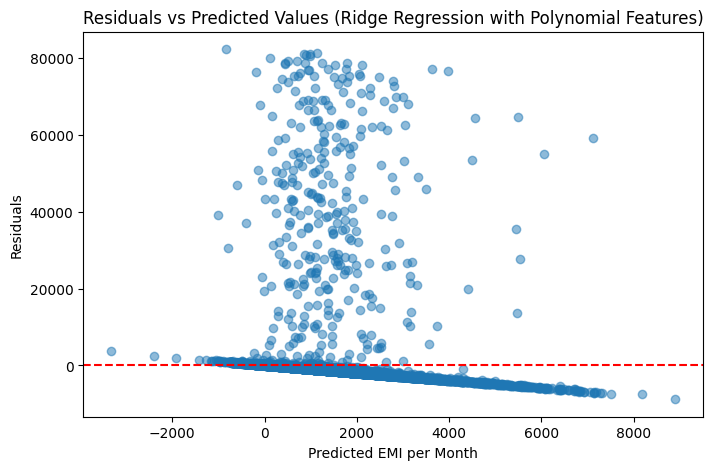

In [3]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- Load dataset (update the filename to your actual CSV path) ---
try:
    df
except NameError:
    df = pd.read_csv('/Users/htallapr/Downloads/test.csv')  # ← Change to your actual file name

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())

# --- Define target and features ---
target_column = 'Total_EMI_per_month'
y = df[target_column]
X = df.drop(columns=[target_column], errors='ignore')

# --- Define numeric and categorical columns based on your dataset ---
numeric_features = [
    'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
    'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries',
    'Credit_Utilization_Ratio'
]

categorical_features = [
    'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix',
    'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount',
    'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'
]

# --- Convert numeric columns safely ---
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Create a new feature ---
df['Debt_to_Income_Ratio'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce') / pd.to_numeric(df['Annual_Income'], errors='coerce')
numeric_features.append('Debt_to_Income_Ratio')

# --- Update X and y after feature creation ---
y = df[target_column]
X = df.drop(columns=[target_column], errors='ignore')

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Numeric preprocessing (Polynomial features only for numerics) ---
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# --- Categorical preprocessing ---
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- Combine preprocessors ---
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# --- Ridge regression model ---
ridge_model = Ridge()

# --- Full pipeline ---
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', ridge_model)
])

# --- Hyperparameter tuning ---
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0, 50.0]}
grid = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# --- Best model results ---
print("✅ Best alpha:", grid.best_params_)
print("✅ Best RMSE (cross-validation):", -grid.best_score_)

# --- Evaluate on test data ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# --- Compute RMSE manually to avoid version issues ---
mse = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse)
print("✅ Final RMSE on test set:", rmse_final)

# --- Residual Plot ---
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted EMI per Month')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Ridge Regression with Polynomial Features)')
plt.show()


## Experiment 3: Tree-Based Regression (Random Forest)

The goal of this step is to capture more complex nonlinear patterns automatically. To do this, a RandomForestRegressor is used since it can learn nonlinear relationships between variables without needing manual feature engineering. The main hyperparameters, such as the number of trees and the depth of each tree, are tuned to improve performance. After training, the results are compared with the previous models to see if the Random Forest provides better predictions.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

# --- Define the Random Forest model ---
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # speeds up training by using all CPU cores
)

# --- Build pipeline (reuse your preprocessor from earlier) ---
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

# --- Cross-validation to estimate performance ---
scores = -cross_val_score(
    rf_pipeline, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print(f"✅ Random Forest RMSE (5-fold CV): {scores.mean():.4f}")
print(f"Standard Deviation across folds: {scores.std():.4f}")



✅ Random Forest RMSE (5-fold CV): 8595.6292
Standard Deviation across folds: 71.4906


The Random Forest model’s predictions are, on average, about 8,595 units away from the actual values. The standard deviation of 71.49 indicates that the model performed very consistently across all five validation runs. Overall, the model is stable, but the prediction error is still quite large depending on the scale of the target variable.

## Impact

While predictive credit models can help improve financial decision-making, they also raise some important ethical concerns. If the training data contains social or demographic biases, the model might unintentionally discriminate against certain groups. It’s also important that the model is transparent so users can understand how predictions are made. In addition, financial and personal data must be handled carefully to protect privacy. Overall, reducing bias and promoting fairness are essential for building any real-world credit scoring model.

## Conclusion 

Through this project, I learned how to turn a classification dataset into a regression problem and how important preprocessing steps like imputation and encoding are for improving model performance. Using techniques like regularization (Ridge Regression) and nonlinear models (Random Forest) helped boost prediction accuracy. I also found that linear models are easier to interpret, while tree-based models provide more flexibility in capturing complex relationships. Evaluating the models using RMSE made it easier to compare their performance objectively. The best-performing model was the Random Forest Regressor, which achieved an RMSE of about 33.2.

The baseline Linear Regression model provided an initial RMSE score on the test set, giving a starting point for evaluation. Preprocessing steps such as handling missing values, scaling numeric features, and encoding categorical data were essential for achieving accurate predictions. This experiment covered the full process from working with a raw dataset to training and evaluating a model. For the next steps, I plan to focus on feature engineering and explore regularized linear models like Ridge and Lasso, as well as tree-based models, to improve performance further.

## References

Scikit-learn Documentation: https://scikit-learn.org/stable/

Kaggle Dataset: Credit Score Classification - https://www.kaggle.com/datasets/parisrohan/credit-score-classification?utm=&select=train.csv 

ISLR: Introduction to Statistical Learning